# Cleaning the Parks dataset
by: Annie Chan

Our initial parks dataset comes from the **[County of LA website](https://egis-lacounty.hub.arcgis.com/datasets/lacounty::countywide-parks-and-open-space-public-hosted/about)**. Since we want to explore park equity in LA's Supervisorial Districts 2 and 5, we will only be focusing on parks that are open access to the public. Second, we will also highlight cemeteries, golf courses, and parkways, as we do not feel that these provide similar benefits as other parks in this dataset. Third, we will be removing unnecessary columns and coming up with a park score for local parks/regional recreation parks (due to data limitations, we are unable to come up with a park score for regional open spaces/natural areas.) Lastly, we will save all these data cleaning steps into a new geojson so that it's easier to work with down the line.

## Dataset info

- tracts: initial geojson from **[LA County Open Source GIS page](https://egis-lacounty.hub.arcgis.com/datasets/339787e096f94c2dbfbf1909698d6c5c/explore)**
- district: initial CSV from **[LA County Census Tracts Viewer page](https://www.arcgis.com/apps/dashboards/e928d021b4d74e5ab4537fac43a3eaf5)**
- tracts_district: merge between the tracts gdf and district df
- parks: initial geojson from the **[County of LA website](https://egis-lacounty.hub.arcgis.com/datasets/lacounty::countywide-parks-and-open-space-public-hosted/about)**
- parks_district: merged the two geodataframes of parks and tracts_district
- parks_d2d5: subset of only the parks in District 2 and 5
- open_parks_d2d5: keep only parks with ACCESS_TYP = 'Open Access'

## Step 1: Import libraries

In [53]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import contextily as ctx #for basemaps on the matplotlib plots
import folium
import branca
import plotly.express as px # for interactive plots

## Step 2: Import census tracts

I'm going to bring in the LA County census tracts and the LA County supervisorial district lines. Next, I'm going to subset the districts to only keep SD2 and SD5. Then I'm going to merge the SD2+SD5 dataset with the census tracts.

In [54]:
tracts = gpd.read_file('data/2020_Census_Tracts.geojson')
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       2496 non-null   int64   
 1   CT20           2496 non-null   object  
 2   LABEL          2496 non-null   object  
 3   ShapeSTArea    2496 non-null   float64 
 4   ShapeSTLength  2496 non-null   float64 
 5   geometry       2496 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 117.1+ KB


The 'CT20' column is an object, good. Now make the FIPS code for tracts for merging purposes later.

In [55]:
tracts['FIPS'] ='06' + '037' + tracts['CT20']
tracts.head(3)

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,FIPS
0,4992,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.29793 34.26323, -118.30082 34.2...",06037101110
1,4993,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.27743 34.25991, -118.27743 34.2...",06037101122
2,4994,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.27818 34.25577, -118.27887 34.2...",06037101220


## Step 3: Import supervisorial districts

In [56]:
district = pd.read_csv(
    'data/All_LA_Census_Tracts_By_Supervisorial_District_2020.csv',
    dtype=
    {
        'CT20': str
    }
)

In [57]:
# make the FIPS code column
district['FIPS'] = '06' + '037' + district['CT20']
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OBJECTID_12    2495 non-null   int64  
 1   Join_Count     2495 non-null   int64  
 2   TARGET_FID     2495 non-null   int64  
 3   CT20           2495 non-null   object 
 4   LABEL          2495 non-null   float64
 5   NAME           2495 non-null   object 
 6   SUP_NAME       2495 non-null   object 
 7   DIST_SUP       2495 non-null   int64  
 8   CITYNAME_ALF   2262 non-null   object 
 9   NAME_1         283 non-null    object 
 10  JURISDICTION   2495 non-null   object 
 11  AREA_NUM       2495 non-null   int64  
 12  AREA_NAME      2495 non-null   object 
 13  Shape__Area    2495 non-null   float64
 14  Shape__Length  2495 non-null   float64
 15  FIPS           2495 non-null   object 
dtypes: float64(3), int64(5), object(8)
memory usage: 312.0+ KB


## Step 4: Merge tracts and district, drop unneeded columns

Now merge tracts and district to get the geometry column.

In [58]:
#this direction matters? tracts is a geodataframe and district is just a dataframe
tracts_district = tracts.merge(district, on = 'FIPS')
tracts_district.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       2495 non-null   int64   
 1   CT20_x         2495 non-null   object  
 2   LABEL_x        2495 non-null   object  
 3   ShapeSTArea    2495 non-null   float64 
 4   ShapeSTLength  2495 non-null   float64 
 5   geometry       2495 non-null   geometry
 6   FIPS           2495 non-null   object  
 7   OBJECTID_12    2495 non-null   int64   
 8   Join_Count     2495 non-null   int64   
 9   TARGET_FID     2495 non-null   int64   
 10  CT20_y         2495 non-null   object  
 11  LABEL_y        2495 non-null   float64 
 12  NAME           2495 non-null   object  
 13  SUP_NAME       2495 non-null   object  
 14  DIST_SUP       2495 non-null   int64   
 15  CITYNAME_ALF   2262 non-null   object  
 16  NAME_1         283 non-null    object  
 17  JURISDICTION   2495 non-n

Let's narrow down the variables in the dataset so it's cleaner and rename the columns for clarity.

In [59]:
tracts_district = tracts_district[['FIPS',
                           'Join_Count',
                           'DIST_SUP',
                           'CITYNAME_ALF',
                           'NAME_1',
                           'JURISDICTION',
                            'geometry']].copy()

In [60]:
#rename the columns for clarity as well
tracts_district.rename(columns={'CITYNAME_ALF': 'CITY_NAME', 'NAME_1': 'UNINCORP_NAME'}, inplace=True)

In [61]:
tracts_district.sample(3)

,FIPS,Join_Count,DIST_SUP,CITY_NAME,UNINCORP_NAME,JURISDICTION,geometry
1321,06037407702,1,1,LA PUENTE,NaN,INCORPORATED CITY,"POLYGON ((-117.95081 34.02808, -117.95090 34.0..."
2133,06037620521,1,2,REDONDO BEACH,NaN,INCORPORATED CITY,"POLYGON ((-118.36132 33.88012, -118.36144 33.8..."
414,06037185102,1,1,LOS ANGELES,NaN,INCORPORATED CITY,"POLYGON ((-118.20797 34.11309, -118.20828 34.1..."


## Step 5: Import parks

In [62]:
parks = gpd.read_file('data/Countywide_Parks_and_Open_Space_(Public_-_Hosted).geojson')

In [63]:
parks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       3012 non-null   int64   
 1   UNIT_ID        3011 non-null   float64 
 2   LMS_ID         1263 non-null   float64 
 3   PARK_NAME      3012 non-null   object  
 4   PARK_LBL       3012 non-null   object  
 5   ACCESS_TYP     3012 non-null   object  
 6   RPT_ACRES      3012 non-null   float64 
 7   GIS_ACRES      3012 non-null   float64 
 8   AGNCY_NAME     3012 non-null   object  
 9   AGNCY_LEV      3012 non-null   object  
 10  AGNCY_TYP      3012 non-null   object  
 11  AGNCY_WEB      3010 non-null   object  
 12  MNG_AGENCY     3012 non-null   object  
 13  COGP_TYP       3011 non-null   object  
 14  NDS_AN_TYP     3009 non-null   object  
 15  NEEDS_ANLZ     3010 non-null   object  
 16  TKIT_SUM       3010 non-null   object  
 17  AMEN_RPT       3010 non-n

## Step 6: Merge parks with tracts_district, then drop unneeded columns

I found this shapely.geometry code on the internet to get to geopandas.overlay, I don't really understand it though

In [64]:
from shapely.geometry import Polygon
geopandas = gpd
parks_district = geopandas.overlay(tracts_district, parks, how='intersection', keep_geom_type=None, make_valid=True)

/tmp/ipykernel_295/557824015.py:3: UserWarning:

`keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



Narrow down the variables again for this parks_d2d5 set. Keeping the same name of the dataset.

In [65]:
parks_district = parks_district[['FIPS','Join_Count','DIST_SUP', 'CITY_NAME','UNINCORP_NAME','JURISDICTION','UNIT_ID','PARK_NAME','ACCESS_TYP',
            'RPT_ACRES','GIS_ACRES','AGNCY_NAME','AGNCY_TYP', 'COGP_TYP','AMEN_RPT','PRKINF_CND','AM_OPNSP','AM_TRLS',
            'TOTAL_GOOD','TOTAL_FAIR', 'TOTAL_POOR', 'RSTRM', 'TYPE','CENTER_LAT','CENTER_LON','Shape__Area', 'Shape__Length','geometry']].copy()

In [66]:
parks_district.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3948 entries, 0 to 3947
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FIPS           3948 non-null   object  
 1   Join_Count     3948 non-null   int64   
 2   DIST_SUP       3948 non-null   int64   
 3   CITY_NAME      3091 non-null   object  
 4   UNINCORP_NAME  939 non-null    object  
 5   JURISDICTION   3948 non-null   object  
 6   UNIT_ID        3947 non-null   float64 
 7   PARK_NAME      3948 non-null   object  
 8   ACCESS_TYP     3948 non-null   object  
 9   RPT_ACRES      3948 non-null   float64 
 10  GIS_ACRES      3948 non-null   float64 
 11  AGNCY_NAME     3948 non-null   object  
 12  AGNCY_TYP      3948 non-null   object  
 13  COGP_TYP       3947 non-null   object  
 14  AMEN_RPT       3946 non-null   object  
 15  PRKINF_CND     3945 non-null   object  
 16  AM_OPNSP       3945 non-null   object  
 17  AM_TRLS        3945 non-n

we're going to take a small break from data merging/cleaning to use plotly to plot the number of parks in each district. This is how we chose Supervisorial Districts 2 and 5 to focus on for our research question, because SD2 has the least parks and SD5 has the most.

In [67]:
counts_parks = parks_district.groupby(['DIST_SUP']).size().reset_index(name='counts')
counts_parks

,DIST_SUP,counts
0,1,565
1,2,462
2,3,981
3,4,873
4,5,1067


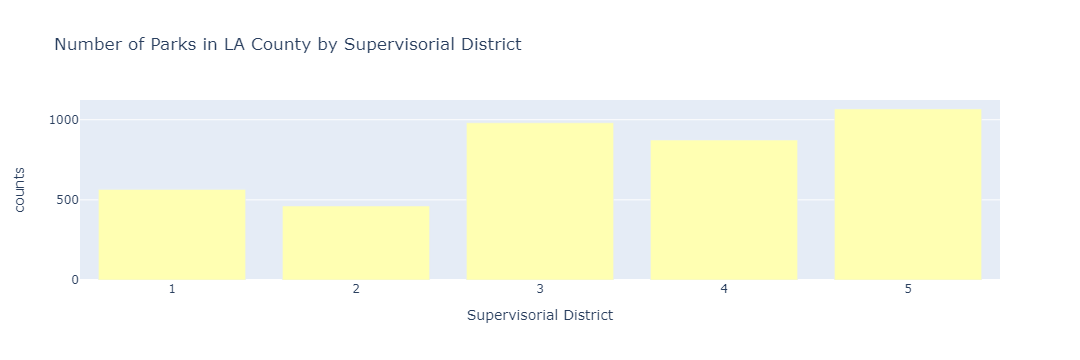

In [68]:
fig = px.bar(counts_parks, x='DIST_SUP', y='counts',
              color_discrete_sequence =['#ffffb2']*len(counts_parks),
             labels={
                     'DIST_SUP': 'Supervisorial District'
                 }, #rename the titles
             title = 'Number of Parks in LA County by Supervisorial District')

fig.show()

Now let's save this plotly plot as html so we can embed it to our storymap later.

In [21]:
fig.write_html("count_parks_plotly.html")

## Step 7: Subset to only keep Supervisorial Districts 2 and 5

In [69]:
parks_d2d5 = parks_district[parks_district.DIST_SUP.isin([2, 5])].copy()
parks_d2d5.sample(5)

,FIPS,Join_Count,DIST_SUP,CITY_NAME,UNINCORP_NAME,JURISDICTION,UNIT_ID,PARK_NAME,ACCESS_TYP,RPT_ACRES,...,TOTAL_GOOD,TOTAL_FAIR,TOTAL_POOR,RSTRM,TYPE,CENTER_LAT,CENTER_LON,Shape__Area,Shape__Length,geometry
3348,06037910810,1,5,NaN,SANTA CLARITA VALLEY,UNINCORPORATED AREA,46211.0,Unnamed site - Santa Clarita Watershed Recreat...,Unknown Access,58.135,...,0.0,0.0,0.0,0.0,Natural Areas,34.471233,-118.332973,2.532027e+06,7752.800496,"POLYGON ((-118.33140 34.46785, -118.33214 34.4..."
1429,06037401602,2,5,LA VERNE,NaN,INCORPORATED CITY,6106.0,Community Center/Civic Center,Open Access,4.811,...,10.0,1.0,0.0,0.0,Local Park,33.896130,-118.312486,2.406686e+05,2746.362463,"POLYGON ((-117.76406 34.11148, -117.76469 34.1..."
142,06037930400,3,5,NaN,ANTELOPE VALLEY,UNINCORPORATED AREA,14635.0,Unnamed site - Mountains Recreation and Conser...,Unknown Access,146.884,...,0.0,0.0,0.0,0.0,Regional Open Space,34.333590,-118.471812,6.397625e+06,18169.106047,"POLYGON ((-118.46888 34.33010, -118.46904 34.3..."
1189,06037310100,1,5,BURBANK,NaN,INCORPORATED CITY,7139.0,City of Burbank Open Space Mountain Reserve 6,Open Access,60.615,...,0.0,0.0,0.0,0.0,Regional Open Space,34.207684,-118.319636,2.640219e+06,11098.017187,"POLYGON ((-118.31453 34.20957, -118.31649 34.2..."
2648,06037621102,1,2,HERMOSA BEACH,NaN,INCORPORATED CITY,6107.0,Greenwood Park (City of Hermosa Beach),Open Access,0.477,...,0.0,0.0,0.0,0.0,Local Park,33.863073,-118.392186,2.079687e+04,755.050442,"POLYGON ((-118.39187 33.86315, -118.39185 33.8..."


## Step 8: Park Score for Local Parks/Regional Recreation Parks

I'm taking the park score analysis and working off Miles' code for Week 7 from the Midterm_Cleaned.ipynb. He figured out how to make a "score" for parks' amenities based on the TOTAL_GOOD, TOTAL_FAIR, and TOTAL_POOR columns. Good is worth 1 point, Fair is worth 0.5, and Poor is worth 0.

The amenities that LA County counted are tennis courts, basketball courts, baseball fields, soccer fields, multi-purpose fields, fitness zones, skateparks, picnic shelters, playgrounds, pools, splash pads, dog parks, gymnasiums, commmunity centers, senior centers, and restrooms.

In [70]:
parks_d2d5['Score'] = (parks_d2d5['TOTAL_GOOD'] + 
                       (parks_d2d5['TOTAL_FAIR']*0.5)) / (parks_d2d5['TOTAL_GOOD'] + parks_d2d5['TOTAL_FAIR'] + parks_d2d5['TOTAL_POOR'])
parks_d2d5['Score'].fillna(0, inplace = True)

In [71]:
#check
parks_d2d5[['PARK_NAME', 'TYPE', 'AMEN_RPT','TOTAL_GOOD', 'TOTAL_FAIR', 'TOTAL_POOR', 'Score']].sample(5)

,PARK_NAME,TYPE,AMEN_RPT,TOTAL_GOOD,TOTAL_FAIR,TOTAL_POOR,Score
2237,Raymond Street Park,Local Park,Yes,0.0,2.0,0.0,0.50
2658,Torrance holding 6,Natural Areas,No,0.0,0.0,0.0,0.00
102,Hansen Dam Park,Regional Recreation Park,Yes,12.0,6.0,2.0,0.75
3231,Lancaster Cemetery,Natural Areas,No,0.0,0.0,0.0,0.00
1387,Gladstone Park (City of Glendora),Local Park,Yes,4.0,1.0,0.0,0.90


One limitation to our park score is that it pretty much only applies to Local Parks (ex: Sunland Park) or Regional Recreation Parks (ex: Kenneth Hahn State Recreation Area). Nearly all rows with AMEN_RPT = No (no amenities reported) will have a score of 0, since the park score is based on conditions of amenities. 

In [72]:
#use this code to look at ALL the columns
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(parks_d2d5[(parks_d2d5['AMEN_RPT'] == 'No') & (parks_d2d5['Score'] > 0)])

,FIPS,Join_Count,DIST_SUP,CITY_NAME,UNINCORP_NAME,JURISDICTION,UNIT_ID,PARK_NAME,ACCESS_TYP,RPT_ACRES,GIS_ACRES,AGNCY_NAME,AGNCY_TYP,COGP_TYP,AMEN_RPT,PRKINF_CND,AM_OPNSP,AM_TRLS,TOTAL_GOOD,TOTAL_FAIR,TOTAL_POOR,RSTRM,TYPE,CENTER_LAT,CENTER_LON,Shape__Area,Shape__Length,geometry,Score
2513,06037600303,1,2,NaN,W ATHENS - WESTMONT,UNINCORPORATED AREA,100110.0,Woodcrest Play Park,Open Access,0.08,0.078948,"Los Angeles, County of",County Agency,Pocket,No,None,None,None,2.0,0.0,0.0,0.0,Local Park,33.939864,-118.299867,3438.975586,362.013666,"POLYGON ((-118.29978 33.93974, -118.29990 33.9...",1.0


But there is one anomaly, Woodcrest Play Park, that has AMEN_RPT = No but a Score of 1. **We'll hard recode this singular row to AMEN_RPT = Yes so that it maintains a park score.**

In [73]:
parks_d2d5.loc[parks_d2d5['PARK_NAME'] == 'Woodcrest Play Park', 'AMEN_RPT'] = 'Yes'

Unfortunately, after exploring the dataset more, there are no other columns we can leverage to build a score for parks with AMEN_RPT = 0. Most of the parks that aren't included in the amenities report are TYPE = 'Natural Areas' or 'Regional Open Space'.

The plotly bar chart below sums up our issue pretty well.

In [74]:
counts_amen_rpt = parks_d2d5.groupby(['AMEN_RPT', 'TYPE']).size().reset_index(name='counts')
counts_amen_rpt

,AMEN_RPT,TYPE,counts
0,No,Local Park,18
1,No,Natural Areas,545
2,No,Regional Open Space,288
3,No,Regional Recreation Park,1
4,Yes,Local Park,648
5,Yes,Regional Open Space,1
6,Yes,Regional Recreation Park,27


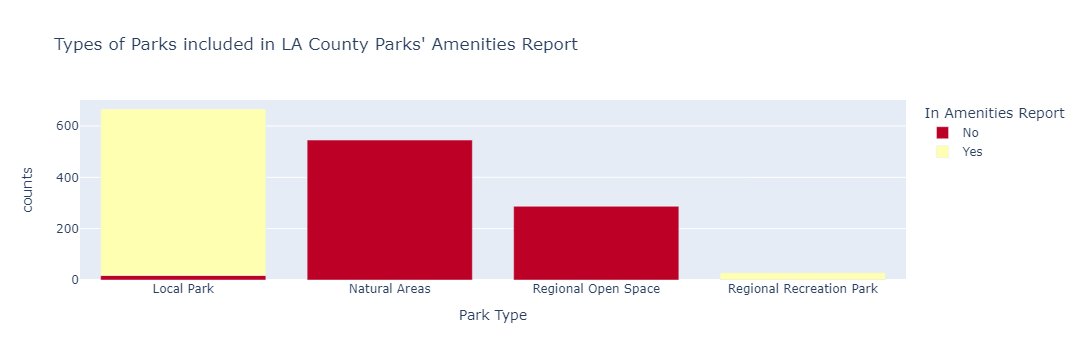

In [83]:
fig = px.bar(counts_amen_rpt, x='TYPE', y='counts',
              color = 'AMEN_RPT',
             labels={
                     'TYPE': 'Park Type', 'AMEN_RPT': 'In Amenities Report'
                 }, #rename the titles
             title = "Types of Parks included in LA County Parks' Amenities Report",
             color_discrete_map={
                 'Yes': '#ffffb2',
                 'No': '#bd0026'
             }
            )

fig.show()

In [84]:
fig.write_html("amen_rpt_by_park_type_plotly.html")

We still want to be able to map this data, but not confuse it with parks that *actually* have a Park Score of 0. So we will set these parks with AMEN_RPT = No to as Park Score of -1.

In [35]:
parks_d2d5.loc[parks_d2d5['AMEN_RPT'] == 'No', 'Score'] = -1

In [36]:
#check that 852 rows were recoded - yes!
parks_d2d5.groupby(['AMEN_RPT', 'Score']).size()

AMEN_RPT  Score    
No        -1.000000    852
Yes        0.000000     79
           0.115385      2
           0.125000      1
           0.142857      1
                      ... 
           0.944444      2
           0.950000      1
           0.954545      6
           0.979167      4
           1.000000    128
Length: 106, dtype: int64

## Step 9: filter to only keep parks that are Open Access

There's a column for the parks' access type, which are Open Access (1241 rows), Unknown Access (144), Restricted Access (79), No Public Access (65). I got these numbers from ```parks_d2d5.value_counts("ACCESS_TYP")```.

We're only going to keep Open Access in our new dataset called **open_parks_d2d5**, since we know for sure these are available to the public.

*(Side note: when I ran value_counts on Unknown Access, most of these rows have a Park Name of 'Unnamed site - Mountains Recreation and Conservation Authority'.)*

In [37]:
open_parks_d2d5 = parks_d2d5[parks_d2d5['ACCESS_TYP']=='Open Access'] #should be 1241
open_parks_d2d5.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1241 entries, 0 to 3906
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FIPS           1241 non-null   object  
 1   Join_Count     1241 non-null   int64   
 2   DIST_SUP       1241 non-null   int64   
 3   CITY_NAME      997 non-null    object  
 4   UNINCORP_NAME  272 non-null    object  
 5   JURISDICTION   1241 non-null   object  
 6   UNIT_ID        1241 non-null   float64 
 7   PARK_NAME      1241 non-null   object  
 8   ACCESS_TYP     1241 non-null   object  
 9   RPT_ACRES      1241 non-null   float64 
 10  GIS_ACRES      1241 non-null   float64 
 11  AGNCY_NAME     1241 non-null   object  
 12  AGNCY_TYP      1241 non-null   object  
 13  COGP_TYP       1241 non-null   object  
 14  AMEN_RPT       1240 non-null   object  
 15  PRKINF_CND     1239 non-null   object  
 16  AM_OPNSP       1239 non-null   object  
 17  AM_TRLS        1239 non-null  

## Step 10: Make new column denoting cemeteries, golf courses, and parkways
In past weeks of analysis, we stumbled upon the fact that some cemeteries, golf courses, and parkways/greenbelts (strips of green grass along a road, sometimes with a walking path) are considered parks. We would like to add a column that denotes this, since we're not convinced this really counts as adequate "parks".

First, I looked at the data pretty extensively using variations of this code: ```with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(parks_d2d5[parks_d2d5['PARK_NAME'].str.contains('Parkway|Greenbelt'))]) ```

Then, I defined a if-else function and applied to a new hodge podge column called **CEMETERY_GOLF_ETC**.

In [41]:
# this code is from the internet
def assign(park_name):
    if 'Cemetery' in park_name:
        return 'Cemetery'
    elif 'Golf' in park_name:
        return 'Golf Course'
    elif 'Parkway' in park_name or 'Greenbelt' in park_name and 'Open' not in park_name:
        return 'Parkway'
    else:
        return 'No Specification'

open_parks_d2d5['CEMETERY_GOLF_ETC'] = open_parks_d2d5['PARK_NAME'].apply(assign)


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
# check for reasonability - good
open_parks_d2d5.value_counts('CEMETERY_GOLF_ETC')

CEMETERY_GOLF_ETC
No Specification    1185
Parkway               31
Golf Course           20
Cemetery               5
Name: count, dtype: int64

In [49]:
open_parks_d2d5[open_parks_d2d5['CEMETERY_GOLF_ETC']!='No Specification'].sample(3)

,FIPS,Join_Count,DIST_SUP,CITY_NAME,UNINCORP_NAME,JURISDICTION,UNIT_ID,PARK_NAME,ACCESS_TYP,RPT_ACRES,...,TOTAL_POOR,RSTRM,TYPE,CENTER_LAT,CENTER_LON,Shape__Area,Shape__Length,geometry,Score,CEMETERY_GOLF_ETC
811,06037238000,1,2,LOS ANGELES,NaN,INCORPORATED CITY,6210.0,98th Street Parkway,Open Access,15.590,...,0.0,0.0,Natural Areas,33.947117,-118.271957,679129.590820,28653.819611,"MULTIPOLYGON (((-118.30260 33.94693, -118.3025...",-1.0,Parkway
541,06037189102,2,5,LOS ANGELES,NaN,INCORPORATED CITY,6204.0,Vermont Parkway (City of Los Angeles),Open Access,4.664,...,0.0,0.0,Regional Open Space,34.027902,-118.291279,203176.970703,10416.004323,"MULTIPOLYGON (((-118.28992 34.11457, -118.2900...",-1.0,Parkway
3314,06037910501,1,5,PALMDALE,NaN,INCORPORATED CITY,46114.0,Dr. Robert C. St. Clair Parkway,Open Access,8.719,...,0.0,0.0,Regional Open Space,34.580997,-118.117143,379733.874023,8740.579297,"MULTIPOLYGON (((-118.11622 34.57602, -118.1161...",-1.0,Parkway


## Step 11: save open_parks_d2d5 gdf as a geojson

In [52]:
# new code from W9 lecture - Export the GeoDataFrame to GeoJSON
open_parks_d2d5.to_file("data/open_parks_d2d5.geojson", driver="GeoJSON")

### End of data cleaning steps